# 1. 卷积神经网
卷积神经网络（CNN），专门为了处理图片而设计的神经网络。基于CNN的体系结构现在在计算机视觉领域无处不在，并且已经变得如此占主导地位，以至于今天几乎所有开发出商业应用程序或参加与图像识别，对象检测或语义分割有关的应用都会用到。
CNN除了准确率高，CNN往往在计算效率上也高，这不仅是因为它们所需的参数比完全连接的架构少，而且卷积易于在GPU内核之间并行化。因此从业人员在可能情况下都会使用CNN，甚至在处理一些一维结构的任务（音频，文本和事件序列分析），CNN的一些巧妙改编也使它们适用于图结构数据和推荐系统。



## 1.1 互相关运算
严格来说，卷积层做得是互相关运算。在这样的层中，输入张量和核张量通过互相关运算被组合以产生输出张量。
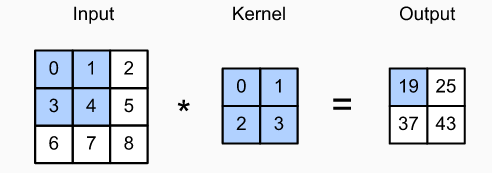


在二维互相关运算中，我们从位于输入张量的左上角的卷积窗口开始，然后将其从左到右以及从上到下在整个输入张量上滑动。当卷积窗口滑动到某个位置时，该窗口中包含的输入张量和内核张量将逐元素相乘，并且将所得张量求和，得出单个标量值。该结果给出了在相应位置的输出张量的值。

In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, init, gluon
from mxnet.gluon import nn
import plotly.graph_objs as go
npx.set_np()

In [2]:
def corr2d(X, K):
    
    h, w = K.shape
    m,n = X.shape
    Y = np.zeros((m-h+1, n-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h, j:j+w]*K).sum()
    return Y

In [3]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = np.array([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

array([[19., 25.],
       [37., 43.]])

## 1.2 卷积层
+ 卷积层使输入和内核进行互相关运算，并添加标量偏差以产生输出。
+ 卷积层的两个参数是内核和标量偏差

基于上面第一的corr2d方法实现二维卷积层，在`__init__`构造函数中，声明weight和bias作为参数。

In [4]:
class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)
        self.bias = self.params.get('bias', shape=(1,))
        
    def forward(self, X):
        return corr2d(X, self.weight.data()) + self.bias.data()

## 1.3 图像边缘检测
一个小栗子用于理解卷积层作用。构建一个6×8 像素的图像：中间的四列为黑色（0），其余为白色（1）。

In [5]:
X = np.ones((6, 8))
X[:, 2:6] = 0
X

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]])

+ 我们构造一个K高度为1且宽度为2 的内核。当我们对输入执行互相关运算时，如果水平相邻元素相同，则输出为0。否则，不为0。

In [6]:
K = np.array([[1.0, -1.0]])

+ 通过互相关计算，从白色到黑色的边缘检测为1，从黑色到白色的边缘检测为-1。所有其他输出取值为0。因此可以检测边缘。

In [7]:
Y = corr2d(X, K)
Y

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

## 1.4 学习内核
使用物体边缘检测中输入数据X和数据Y来学习内核K。
+ 构造一个卷积层，初始化随机数组
+ 每一次迭代中，使用平方误差比较Y和卷积层数据
+ 然后通过autogrid更新权重
+ 为了简单，忽略了偏差use_bias=False

In [8]:
conv2d = nn.Conv2D(1, kernel_size=(1, 2), use_bias=False)
conv2d.initialize()

X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)

for i in range(10):
    with autograd.record():
        Y_hat = conv2d(X)
        l = (Y_hat-Y) ** 2
    l.backward()
    # 更新权重
    conv2d.weight.data()[:] -= 3e-2 * conv2d.weight.grad()
    print(f'batch {i + 1}, loss {float(l.sum()):.4f}')

batch 1, loss 12.0800
batch 2, loss 4.9493
batch 3, loss 2.0281
batch 4, loss 0.8313
batch 5, loss 0.3408
batch 6, loss 0.1398
batch 7, loss 0.0574
batch 8, loss 0.0236
batch 9, loss 0.0097
batch 10, loss 0.0040


+ 学习到的张量跟之前定义的[1, -1]已经非常接近了

In [9]:
conv2d.weight.data().reshape(1,2)

array([[ 0.9895   , -0.9873705]])

## 1.5 特征图和感受野
二维卷积层输出的二维数组可以看作输入在空间维度（宽和高）上某一级的表征，也叫特征图（feature map）。
影响元素 x 的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做 x 的感受野（receptive field）。

# 2. 填充和步幅
上面例子中, 我们使用高和宽为3的输入与高和宽为2的卷积核得到高和宽为2的输出。一般来说，假设输入形状是$n_h×n_w$，卷积核窗口形状是$k_h×k_w$，那么输出形状将会是  $(n_h−k_h+1)×(n_w−k_w+1)$ 。因此，卷积层的输出形状由输入的形状和卷积核的形状确定。卷积层的输出形状由输入形状和卷积核窗口形状决定。除此之外我们可以通过填充和步幅对给定形状的输入和卷积核改变输出形状。

## 2.1 填充
由于图像边缘的问题可能导致扫描不全，信息丢失，对于任何给定的卷积，我们可能只会损失几个像素，但是许多连续卷积层的话损失就会叠加。解决这一问题的方法是在图像的边界外填充额外的像素，从而正价图像的有效尺寸。通常会设置额外像素为0。

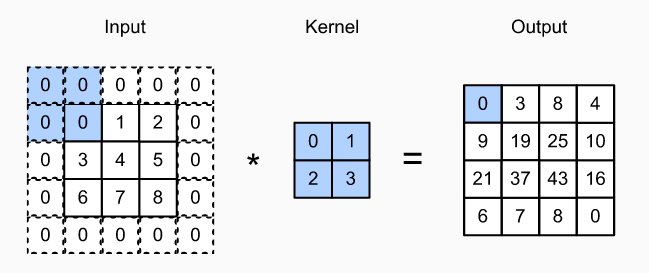

卷积神经网络经常使用奇数高和宽的卷积核，如1、3、5和7，所以两端上的填充个数相等。对任意的二维数组X，设它的第i行第j列的元素为X[i,j]。当两端上的填充个数相等，并使输入和输出具有相同的高和宽时，我们就知道输出Y[i,j]是由输入以X[i,j]为中心的窗口同卷积核进行互相关计算得到的。

通过一个例子说明，创建一个高度和宽度为3的二维卷积层，并在所有面上应用1个填充像素。给定高度和宽度为8的输入，我们发现输出的高度和宽度也为8。

In [10]:
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    
    # 这里添加的（1,1）纬度分别为批次和通道都是1
    X= X.reshape((1,1) + X.shape)
    Y = conv2d(X)

    return Y.reshape(Y.shape[2:])  # 去掉批次和通道的纬度

conv2d = nn.Conv2D(1, kernel_size=3, padding=1)
X = np.random.uniform(size=(8, 8))
comp_conv2d(conv2d, X).shape

(8, 8)

+ 当卷积核的高度和宽度不同时，我们可以通过为高度和宽度设置不同的填充数来使输出和输入具有相同的高度和宽度。

In [11]:
conv2d = nn.Conv2D(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

(8, 8)

## 2.2 步幅
在前面的示例中都是内核每次只移动一个单位。但是，有时为了提高计算效率或因为我们希望降低采样率，我们一次将窗口移动一个以上元素，从而跳过了中间位置。
我们将每张幻灯片所经过的行数和列数称为步幅（stride）。
下图中在高上步幅为3、在宽上步幅为2的二维互相关运算。可以看到，输出第一列第二个元素时，卷积窗口向下滑动了3行，而在输出第一行第二个元素时卷积窗口向右滑动了2列。

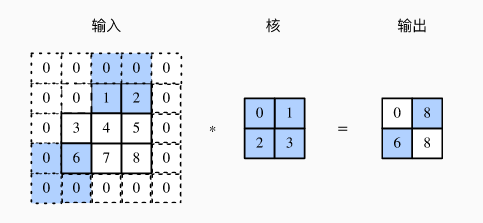

下面，我们将高度和宽度的跨度都设置为2，从而将输入的高度和宽度减半。

In [12]:
conv2d = nn.Conv2D(1, kernel_size=3, padding=1, strides=2)
comp_conv2d(conv2d, X).shape

(4, 4)

为了表述简洁，当输入的高和宽两侧的填充数分别为$p_h$和$p_w$时，我们称填充为$(p_h,p_w)$。特别地，当$p_h=p_w=p$时，填充为p。当在高和宽上的步幅分别为$s_h$和$s_w$时，我们称步幅为$(s_h,s_w)$。特别地，当$s_h=s_w=s$时，步幅为s。在默认情况下，填充为0，步幅为1。

# 3.多通道

彩色图片都是多通道的（例如，彩色图像具有标准的RGB通道以指示红色，绿色和蓝色的数量）和多个通道的卷积层，但到目前为止，我们简化了所有通过仅使用单个输入和单个输出通道的数值示例。这使我们可以将输入，卷积核和输出视为二维张量。
每个RGB输入图像都有形状 3×h×w 。我们将此尺寸为3的轴称为通道尺寸。

## 3.1 多通道输入
当  $c_i$>1 ，我们需要一个包含形状张量的内核  $k_h×k_w$ 对于每个输入通道。串联这些 $c_i$  张量一起产生形状的卷积核  $c_i×k_h×k_w$ 。由于输入和卷积内核分别具有 $c_i$  通道，我们可以针对每个通道在输入的二维张量和卷积内核的二维张量上执行互相关运算，  $c_i$ 结果相加（在通道上求和）以生成二维张量。这是多通道输入和多输入通道卷积内核之间二维互相关的结果。

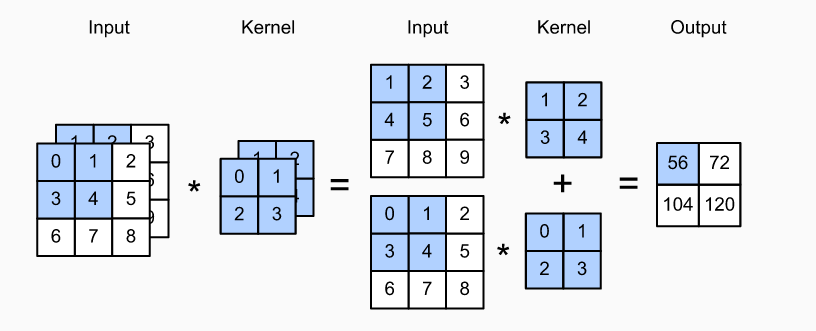

通过实例证明一下：

In [13]:
def corr2d_multi_in(X, K):

    return sum(corr2d(x, k) for x, k in zip(X, K))

X = np.array([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = np.array([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

array([[ 56.,  72.],
       [104., 120.]])

## 3.2 多个通道输出

不管输入通道有多少，到目前为止，我们总是以一个输出通道结束。在最流行的神经网络体系结构中，实际上随着神经网络的更有效而增加通道的尺寸，通常是降低采样以换取空间分辨率以获得更大的通道深度。

 $c_i$  和 $c_o$  输入和输出通道数，分别为  $k_h$  和 $k_w$ 是内核的高度和宽度。为了获得具有多个通道的输出，我们可以创建形状的内核张量 $c_i×k_h×k_w$  对于每个输出通道。我们将它们串联在输出通道维度上，以便卷积核的形状为  $c_o×c_i×k_h×k_w$。

In [14]:
def corr2d_multi_in_out(X, K):

    return np.stack([corr2d_multi_in(X, k) for k in K], 0)

通过叠加三个内核，组成一个新的内核

In [15]:
K = np.stack((K, K + 1, K + 2))
K.shape

(3, 2, 2, 2)

In [16]:
corr2d_multi_in_out(X, K)

array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]])

## 3.3 $1X1$ 卷积层

$1×1$  卷积，即 $ k_h=k_w=1$ ，似乎没有多大意义。毕竟，卷积使相邻像素相关。一种$ 1×1$ 卷积显然没有。尽管如此，它们还是流行的操作，有时会包含在复杂的深度网络的设计中。

由于使用了最小窗口，因此  $1×1$ 卷积失去了较大的卷积层识别模式的能力,唯一的计算 $1×1$  卷积发生在通道尺寸上。

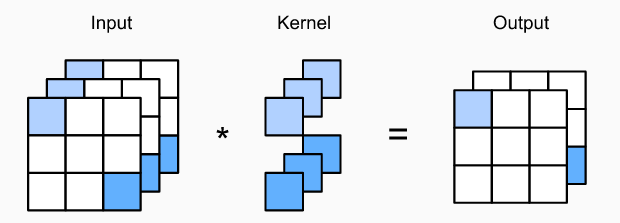

实践一下：我们实现了  1×1 使用全连接层进行卷积。唯一的事情是我们需要在矩阵乘法之前和之后对数据形状进行一些调整。

In [17]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = np.dot(K, X)  
    return Y.reshape((c_o, h, w))

上述函数等效于先前实现的互相关函数 corr2d_multi_in_out。让我们用一些样本数据进行检查。

In [18]:
X = np.random.normal(0, 1, (3, 3, 3))
K = np.random.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(d2l.reduce_sum(np.abs(Y1 - Y2))) < 1e-6

# 4. 池化层
在处理图像时，我们希望逐渐降低隐藏的空间分辨率，聚集信息，以使我们在网络中越往上走，每个隐藏节点的感受野更敏感。在边缘检测应用中，我们构造卷积核从而精确地找到了像素变化的位置。实际图像里，我们感兴趣的物体不会总出现在固定位置：即使我们连续拍摄同一个物体也极有可能出现像素位置上的偏移。这会导致同一个边缘对应的输出可能出现在卷积输出Y中的不同位置，进而对后面的模式识别造成不便。

这里介绍池化层（pooling）层，其有两个作用：减轻卷积层对位置的敏感性以及空间下采样表示的敏感性。

## 4.1 最大池化层和平均池化层
池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出。不同于卷积层里计算输入和核的互相关性，池化层直接计算池化窗口内元素的最大值或者平均值。该运算也分别叫做最大池化或平均池化。在二维最大池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当池化窗口滑动到某一位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

池化窗口形状为  p×q  被称为  p×q 池层。池化操作称为 p×q  集中。

构建一个二维池化层，与corr2d相比，这里没有内核，将输出计算为输入中每个区域的最大值或平均值。

In [19]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = np.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [20]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

array([[4., 5.],
       [7., 8.]])

## 4.2 填充、步幅和通道
用法基本同卷积层

# 5. 卷积神经网络（LeNet）

之前我们构造了一个含单隐藏层的多层感知机模型来对Fashion-MNIST数据集中的图像进行分类。每张图像高和宽均是28像素。我们将图像中的像素逐行展开，得到长度为784的向量，并输入进全连接层中。现在可以使用卷积层处理，可以保留图片本来的空间结构，此外还可以享受更多的简化模型，这些模型需要更少的参数。

## 5.1 LeNet
LeNet，它是最早发布的CNN之一，以其在计算机视觉任务上的性能引起广泛关注。该模型由当时的AT＆T贝尔实验室研究员Yann LeCun引入（并以其命名），目的是识别图像中的手写数字。

LeNet分为卷积层块和全连接层块两个部分：
+ 由两个卷积层组成的卷积编码器；
+ 由三个完全连接的层组成的密集块；

每个卷积块中的基本单元是卷积层，S型激活函数以及随后的平均池化操作。请注意，尽管ReLU和max-pooling的工作效果更好，但在1990年代尚未发现这些发现。每个卷积层使用一个  5×5 内核和S型激活函数。这些层将空间排列的输入映射到多个二维特征图，通常会增加通道数。第一卷积层具有6个输出通道，而第二个卷积层具有16个输出通道。  2×2  合并操作（第2步）将维度降低了  4 通过空间下采样。卷积块发出一个输出，该输出的形状为（批大小，通道数，高度，宽度）。

LeNet的密集模块具有三个完全连接的层，分别具有120、84和10个输出。因为我们仍在执行分类，所以10维输出层对应于可能的输出类别的数量。

下面构建LeNet的神经网络，我们对原始模型略加自由，在最后一层中删除了高斯激活。除此之外，该网络与原始LeNet-5架构匹配。：

In [21]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        # Dense会默认将(批量大小, 通道, 高, 宽)形状的输入转换成(批量大小, 通道 * 高 * 宽)形状的输入
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

## 5.2 训练

现在我们已经实现了模型，让我们进行一个实验，看看LeNet在Fashion-MNIST上的表现如何。

### 5.2.1 获取数据
使用d2l获取数据，同时为了更快的训练使用gpu

In [22]:
ctx = npx.gpu() if npx.num_gpus() > 0 else npx.cpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

+ 训练和获取准确率函数，以及可视化都用MLP中使用的那些，lr稍微提高到0.9，损失函数依旧是交叉熵

In [23]:
def accuracy(y_hat, y): 
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(d2l.reduce_sum(cmp))

def train_epoch(net, train_iter, loss, updater):
    
    l_sum = acc_rate = total = 0
    
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
        
    for X,y in train_iter:
        X = X.copyto(ctx)
        y = y.copyto(ctx)
        with autograd.record():
            pre_y = net(X)
            l = loss(pre_y, y)
        l.backward()
        updater(y.size)
        l_sum += float(l.sum())
        acc_rate += accuracy(pre_y, y)
        total += y.size
    return l_sum/total, acc_rate/total

def evaluate_accuracy(net, data_iter):  

    match_num = total_num = 0
    for _, (X, y) in enumerate(data_iter):
        X = X.as_in_context(ctx)
        y = y.as_in_context(ctx)
        match_num += accuracy(net(X), y)
        total_num += y.size
    return match_num / total_num

def train(net, train_iter, test_iter, epochs, lr):
    
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd',  {'learning_rate': lr})
    l_lst, acc_lst, test_acc_lst = [], [], []
    timer = d2l.Timer()
    for epoch in range(epochs):
        timer.start()
        l, acc = train_epoch(net, train_iter, loss, trainer)
        timer.stop()
        test_acc = evaluate_accuracy(net, test_iter)
        l_lst.append(l)
        acc_lst.append(acc)
        test_acc_lst.append(test_acc)
    print(f'loss {l:.3f}, train acc {acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{timer.sum():.1f} sec '
          f'on {str(ctx)}')
    return [l_lst, acc_lst, test_acc_lst]

def draw_graph(result):
    data = []
    colors = ['aquamarine', 'orange', 'hotpink']
    names = ['train loss', 'train acc', 'test acc']
    symbols = ['circle-open', 'cross-open', 'triangle-up-open']
    for i, info in enumerate(result):
        trace = go.Scatter(
            x = list(range(1, num_epochs+1)),
            y = info,
            mode = 'lines+markers',
            name = names[i],
            marker = {
                'color':colors[i],
                'symbol':symbols[i],
            },
        )
        data.append(trace)
    fig = go.Figure(data = data)
    fig.update_layout(xaxis_title='epochs', width=800, height=480)
    fig.show()

训练和评估LeNet-5模型。

In [28]:
num_epochs, lr = 40, 0.9
result = train(net, train_iter, test_iter,  num_epochs, lr)

loss 0.289, train acc 0.893, test acc 0.880
77.7 sec on gpu(0)


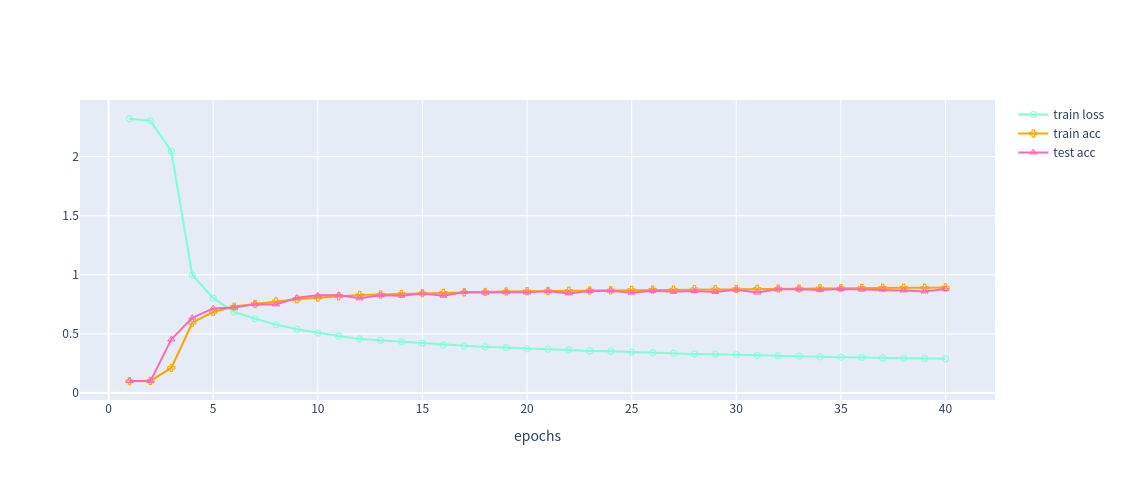

In [29]:
draw_graph(result)